In [179]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Tuple
from torch.distributions import Categorical
from torch.nn.functional import one_hot
import numpy as np
import matplotlib.pyplot as plt

# Networks

In [180]:
class C_Network(nn.Module):
    def __init__(self, observation_space: int, action_space: int, hidden_size: int=32, output_size: int=6):
        super(C_Network, self).__init__()
        self.layer1 = nn.Linear(observation_space + action_space, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, observation: torch.Tensor, action: torch.Tensor)-> torch.Tensor:

        inputs = torch.cat((observation, action), dim=-1)
        x = torch.relu(self.layer1(inputs))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x
        
        
class N_Network(nn.Module):
    def __init__(self, observation_space: int, hidden_size: int=32, output_size: int=6):
        super(N_Network, self).__init__()
        self.layer1 = nn.Linear(observation_space, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, observation: torch.Tensor)-> torch.Tensor:
        x = torch.relu(self.layer1(observation))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x
    
class CENNetwork(nn.Module):
    def __init__(self, observation_space: int, action_space: int, hidden_size: int=32, output_size: int=6, alpha: float=0.5):
        super(CENNetwork, self).__init__()
        self.c_network = C_Network(observation_space, action_space, hidden_size, output_size)
        self.n_network = N_Network(observation_space, hidden_size, output_size)
        params = list(self.c_network.parameters()) + list(self.n_network.parameters())
        self.alpha = alpha
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(params=params, lr=0.0001)
    
    def forward(self, observation: torch.Tensor, action: torch.Tensor)-> Tuple[torch.Tensor, torch.Tensor]:
        h_a = self.c_network(observation, action)
        h_n = self.n_network(observation)
        return h_a, h_n
    
    def train(self, observation: torch.Tensor,
              action: torch.Tensor,
              next_observation: torch.Tensor)-> Tuple[torch.Tensor, float]:
        delta_obs = next_observation - observation
        e_a, e_n = self.forward(observation, action)
        self.optimizer.zero_grad()
        loss = self.criterion(e_a + e_n, delta_obs) + self.alpha * self.criterion(e_n, delta_obs)
        loss.backward()
        self.optimizer.step()
        return e_a.detach(), loss.item()

In [181]:
class Policy(nn.Module):
    def __init__(self,observation_space: int, action_space: int):
        super(Policy, self).__init__()

        self.pi = nn.Sequential(nn.Linear(observation_space,256),
                                nn.ReLU(),
                                nn.Linear(256, action_space)
                                )
    
    def forward(self, x):
        x = self.pi(x)
        dist = Categorical(logits=x)
        action = dist.sample()
        logprob = dist.log_prob(action)
        return action, logprob

def calc_discounted_rewards(rewards, dones, gamma=0.99):
    R = 0
    discounted = []
  
    for idx in reversed(range(len(rewards))):
        R = rewards[idx] + R * gamma * dones[idx]
        discounted.insert(0, R.unsqueeze(-1))
    return discounted

In [182]:
def test_current_model():
    state = env.reset()
    
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        action, _ = pi(state)
        next_state, reward, done, _ = env.step(action.numpy()[0])
        state = next_state
        total_reward += reward
    env.reset()
    return total_reward

Step: 1000 | Reward: 25.0
Step: 2000 | Reward: 36.0
Step: 3000 | Reward: 50.0
Step: 4000 | Reward: 129.0
Step: 5000 | Reward: 41.0
Step: 6000 | Reward: 54.0
Step: 7000 | Reward: 37.0
Step: 8000 | Reward: 112.0
Step: 9000 | Reward: 18.0
Step: 10000 | Reward: 184.0
Step: 11000 | Reward: 102.0
Step: 12000 | Reward: 34.0
Step: 13000 | Reward: 86.0
Step: 14000 | Reward: 31.0
Step: 15000 | Reward: 122.0
Step: 16000 | Reward: 153.0
Step: 17000 | Reward: 200.0
Step: 18000 | Reward: 96.0
Step: 19000 | Reward: 150.0
Step: 20000 | Reward: 113.0
Step: 21000 | Reward: 200.0
Step: 22000 | Reward: 33.0
Step: 23000 | Reward: 183.0
Step: 24000 | Reward: 160.0
Step: 25000 | Reward: 95.0
Step: 26000 | Reward: 200.0
Step: 27000 | Reward: 50.0
Step: 28000 | Reward: 200.0
Step: 29000 | Reward: 136.0
Step: 30000 | Reward: 75.0
Step: 31000 | Reward: 144.0
Step: 32000 | Reward: 155.0
Step: 33000 | Reward: 98.0
Step: 34000 | Reward: 161.0
Step: 35000 | Reward: 134.0
Step: 36000 | Reward: 200.0
Step: 37000 | Rew

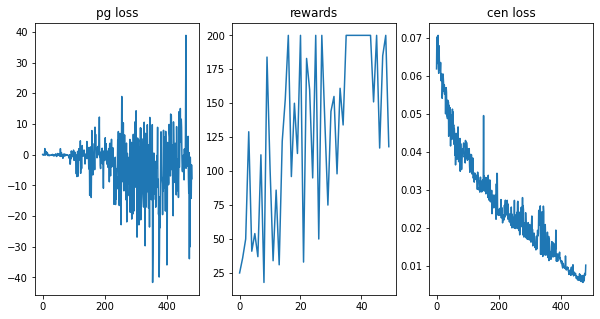

In [186]:
env = gym.make("CartPole-v0") 
observation_size = env.observation_space.shape[0]
action_size = env.action_space.n

frame_idx = 0
max_frames = 50000

pi = Policy(observation_space=observation_size, action_space=action_size)
cen_network = CENNetwork(observation_space=observation_size,
                         action_space=action_size,
                         hidden_size=32,
                         output_size=observation_size,
                         alpha=0.01)

optimizer = optim.Adam(pi.parameters(),lr=0.001)

total_rewards = []
total_loss = []
cen_losses = []

train_cen = True
reward_type = "intrinsic" # "intrinsic", "real"


while frame_idx < max_frames:
    
    states = []
    actions = []
    next_states = []
    log_probs = []
    rewards = []
    final_state = []
    done = False
    state = env.reset()
  
    while not done:
        state_v = torch.from_numpy(state).unsqueeze(0).float()
        action, log_prob = pi(state_v)
        new_state, reward, done, _ = env.step(action.item())
        
        states.append(state_v)
        next_state_v = torch.from_numpy(new_state).unsqueeze(0).float()
        next_states.append(next_state_v)
        actions.append(action.detach())
        log_probs.append(log_prob)
        rewards.append(torch.from_numpy(np.array([reward])).float())
        final_state.append(torch.from_numpy(np.array([1-done])).int())

        state = new_state
        frame_idx += 1


        if frame_idx % 1000 == 0:
            total_reward = test_current_model()
            print("Step: {} | Reward: {}".format(frame_idx, total_reward))
            total_rewards.append(total_reward)
    cen_loss = 0
    # train CAN
    if train_can: 
        states = torch.cat(states)
        next_states = torch.cat(next_states)
        actions = torch.cat(actions)
        action_encoding = one_hot(actions, action_size)
        intrinsic_reward, cen_loss = cen_network.train(states, action_encoding, next_states)
        intrinsic_reward = intrinsic_reward.sum(1, keepdim=True).detach().squeeze()

    cen_losses.append(cen_loss)

    
    # train PG
    if reward_type == "real" and not train_cen:
        rewards = torch.cat(rewards)
    elif reward_type == "real" and train_cen:
        rewards = torch.cat(rewards) + intrinsic_reward
    elif reward_type == "intrinsic" and train_cen:
        rewards = intrinsic_reward
    else:
        rewards = torch.zeros(len(rewards))

    dones = torch.cat(final_state)
    disc_rewards = torch.cat(calc_discounted_rewards(rewards, dones)).unsqueeze(-1)
    baseline = disc_rewards.mean()
    loss = (-torch.cat(log_probs).unsqueeze(-1) * (disc_rewards-baseline)).sum()

    total_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.figure(figsize = (10,5))
plt.subplot(1,3,1)
plt.title("pg loss")
plt.plot(total_loss)
plt.subplot(1,3,2)
plt.title("rewards")
plt.plot(total_rewards)
plt.subplot(1,3,3)
plt.title("cen loss")
plt.plot(cen_losses)